<a href="https://colab.research.google.com/github/mateusz-wozny/IMO/blob/main/GreedyCycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def createDistanceMatrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]
  return np.array(outputMatrix)

In [4]:
def chooseNearestVertex(matrix, used_vertexes, node):
  return np.argmin([matrix[node][i] if i not in used_vertexes and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [5]:
def calculateCycleLength(matrix, vertexes):
  length = 0
  for graph in vertexes:
    length += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])

#   print(length)
  return length

In [28]:
def find_nearest(matrix, lista, unvisited):
    df = matrix[:, lista][unvisited, :]
    indx, indy = np.unravel_index(df.argmin(), df.shape)
    return unvisited[indx], lista[indy]

In [29]:
def random_heuristic(matrix, start):
    N = matrix.shape[0]
    a = random.sample(range(N), N)
    list1 = a[:N//2]
    list1.append(list1[0])
    list2 = a[N//2:]
    list2.append(list2[0])
    return [list1, list2]

In [161]:
def nearest_neighbor(matrix, start):
    end = np.argmax(matrix[start, :])
    unvisited = list(range(matrix.shape[0]))
    unvisited.remove(start)
    unvisited.remove(end)
    list1 = [start]
    list2 = [end]
    while len(unvisited) != 0:
        nearest, vertex = find_nearest(matrix, list1, unvisited)
        list1.insert(list1.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
        if len(unvisited) == 0:
          break
        nearest, vertex = find_nearest(matrix, list2, unvisited)
        list2.insert(list2.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
    list1.append(start)
    list2.append(end)

    return [list1, list2]

In [189]:
def greedyCycle(matrix, start_node):
    #Starting node 2
    start_node_2 = np.argmax(matrix[start_node])

    #Choosing nearest vertex for cycles
    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    #Creating cycles
    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    #Calculating cycles
    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]

        z = np.inf
        x = np.inf
        c = np.inf

        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                if value < z:
                    z = value
                    x = j + 1
                    c = nearest

        if len(cycles[0]) <= len(cycles[1]):
            cycles[0].insert(x, c)
        else:
            cycles[1].insert(x, c)

    return cycles

In [219]:
def two_regret(matrix, start_node):
    start_node_2 = np.argmax(matrix[start_node])

    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]
        z = -np.inf
        x = np.inf
        c = np.inf
        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            values = {}
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                values.update({j:value})
            values = dict(sorted(values.items(), key= lambda x:x[1]))
            keys = list(values.keys())
            value = values[keys[1]] - 1.5*values[keys[0]]
            if value > z:
                z = value
                x = keys[0] + 1
                c = nearest

            
        if len(cycles[0]) <= len(cycles[1]):
                cycles[0].insert(x, c)
        else:
                cycles[1].insert(x, c)

    return cycles

In [225]:
def draw_plot(vertices, visited, length, filename):
  for graph in visited:
    x = vertices[graph, 0]
    y = vertices[graph,1]
    plt.plot(x, y)
  plt.scatter(vertices[:, 0], vertices[:, 1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

In [226]:
def draw_best(ver_data, lengths, heuris, filename):
  best_start_node = np.argmin(lengths)
  distance_matrix = createDistanceMatrix(ver_data)
  vertexes = heuris(distance_matrix, best_start_node)
  min_length = lengths[best_start_node]
  draw_plot(ver_data, vertexes, min_length, filename)

In [206]:
def test(n, heuris, ver_data):
  distance_matrix = createDistanceMatrix(ver_data)
  lengths = []
  for i in range(n):
    start_node = i
    vertexes = heuris(distance_matrix, start_node)
    length = calculateCycleLength(distance_matrix, vertexes)
    lengths.append(length)
  return lengths

In [238]:
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])

In [245]:
#Four heuris to choose: random_heuristic, nearest_neighbor, greedyCycle, two_regret 
lengths = test(100, heuris = greedyCycle,ver_data =  ver_data)
print(f'{round(sum(lengths)/len(lengths))} ({min(lengths)}-{max(lengths)})')

28453 (27180-30197)


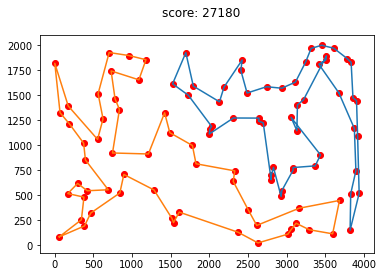

In [246]:
draw_best(ver_data, lengths, greedyCycle, 'cycleB')